In [1]:
from sympy import Symbol,solve
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats
%matplotlib inline
r_m=76.2
beta_T=0.82
h_0=2.46
c=0.05
x_f=26.6
beta_f=0.28
q_f=0.83
A=3.55
beta_g=beta_f
x_g=x_f
p=10
N=5000

In [2]:
#Firing rate pattern
xi_pattern=np.random.normal(0,1,size=(p,N))
r_pattern=r_m/(1+np.exp(-beta_T*(xi_pattern-h_0)))
print(r_pattern)

[[ 3.72347602  5.55130081 25.43485446 ... 18.98093707 10.86434459
   6.43030113]
 [ 6.68252319  3.73134127  4.05012709 ...  1.58427506 12.0329716
  11.88932683]
 [12.26950607  3.86503481 12.59832562 ...  4.0655393  10.05382179
   6.95235652]
 ...
 [ 5.77395872 10.99526031  2.14103786 ... 13.4917059  11.77677592
  15.8696527 ]
 [11.26027668  8.29518631 21.28050113 ... 16.71526705  4.09406453
   3.07192113]
 [ 9.35911839  6.45470607  9.32897761 ...  4.0973527   4.2993738
   6.70088092]]


In [3]:
# Structral connectivity matrix
C=np.zeros((N,N),dtype='int8')
for i in range(N):
    for j in range(N):
        if random.uniform(0,1)<c:
            C[i,j]=1

In [4]:
#x = Symbol('x')
#def func(z):
#    I=np.exp(-z**2/2)*(2*x-1+np.tanh(beta_g*(r_m/(1+np.exp(-beta_T*(z-h_0)))-x_g)))
#    return I
#Sum2=0
#for i in range(N):
#    Sum2=Sum2+func(xi_pattern[0,i])
#q_g=solve(Sum2,x)[0]
#print(q_g)

In [5]:
#Final connectivity matrix J
q_g=0.99
def f(r):
    return 0.5*(2*q_f-1+np.tanh(beta_f*(r-x_f)))
def g(r):
    return 0.5*(2*q_g-1+np.tanh(beta_g*(r-x_g)))
def phi(xi):
    return r_m/(1+np.exp(-beta_T*(xi-h_0)))

In [6]:
#equation 2
J=np.zeros((N,N))
Sum=np.zeros((N,N))
for k in range(p):
    Sum=Sum+np.dot(f(np.transpose(r_pattern[k])).reshape(N,1),g(r_pattern[k]).reshape(1,N))
J=A*C/c/N*Sum
for i in range(N):
    J[i,i]=0

In [7]:
# initial firing rate
r0=np.random.uniform(0,5,N)
#for i in range(p):
#    for j in range(N):
#        r0[j]=np.random.normal(r_pattern[i,j],1)
print(r0)

[0.24555759 2.56677455 0.83993443 ... 4.60288852 0.32187695 4.52363909]


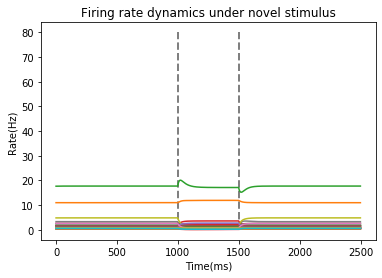

In [8]:
#Novel stimulus
t_p=1000
t_max=2500+t_p
r=np.zeros((N,t_max))
tau=20
t_pre=1000+t_p
t_delay=1500+t_p
dt=1
I0=1
E_novel=np.zeros((p,t_max))
#E_novels=np.zeros(t_max)
for i in range(p):
    ita=np.random.normal(0,1,size=N)
    I=I0*ita
    r[:,0]=r0
    for t in range(1,t_pre):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
        E_novel[i,t]=-1/2*np.sum(np.dot(r[:,t].reshape(N,1),r[:,t].reshape(1,N))*J)
    for t in range(t_pre,t_delay):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(I+xi))/tau*dt #equation 1
        E_novel[i,t]=-1/2*np.sum(np.dot(r[:,t].reshape(N,1),r[:,t].reshape(1,N))*J)
    for t in range(t_delay,t_max):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
        E_novel[i,t]=-1/2*np.sum(np.dot(r[:,t].reshape(N,1),r[:,t].reshape(1,N))*J)
    #E_novels[i]=-1/2*np.sum(np.dot(r[:,t_pre-1].reshape(N,1),r[:,t_pre-1].reshape(1,N))*J)
plt.figure()
plt.title('Firing rate dynamics under novel stimulus')
plt.xlabel('Time(ms)')
plt.ylabel('Rate(Hz)')
plt.vlines(t_pre-t_p, 0,80, colors = "grey", linestyles = "dashed",linewidth=2)
plt.vlines(t_delay-t_p, 0,80, colors = "grey", linestyles = "dashed",linewidth=2)
for i in range(30):
    plt.plot(range(0,t_max-t_p),r[i,t_p:t_max])
r1=np.copy(r)
#plt.savefig('Figures/novel_stimulus.png')

import seaborn as sns
plt.figure()
plt.title('Firing rate distribution under novel stimulus')
plt.xlabel('Rate(Hz)')
plt.ylabel('Probability Density')
sns.kdeplot(r[:,t_delay-1],label='Presentation')
sns.kdeplot(r[:,t_max-1],label='Delay')
plt.savefig('Figures/distribution_novel.png')

#Overlap
import scipy.stats
plt.figure()
plt.ylim(-0.2,1)
plt.title('Overlap under novel stimulus')
plt.xlabel('Time(s)')
plt.ylabel('Overlap(m)')

for i in range(p):
    ita=np.random.normal(0,1,size=N)
    I=I0*ita
    r[:,0]=r0
    for t in range(1,t_pre):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
    for t in range(t_pre,t_delay):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(I+xi))/tau*dt #equation 1
    for t in range(t_delay,t_max):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
    p_r=np.zeros(t_max-t_p)
    for t in range(0,t_max-t_p):
        p_r[t]=scipy.stats.pearsonr(r[:,t+t_p],r_pattern[i])[0]
    plt.plot(range(0,t_max-t_p),p_r)
plt.savefig("Figures/overlap_novel.png")

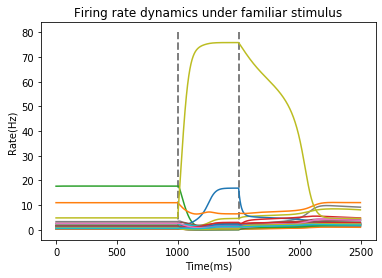

In [9]:
#Familiar Stimulus
E_familiar=np.zeros((p,t_max))
#E_familiars=np.zeros(t_max)
for i in range(p):
    I=I0*xi_pattern[i]
    r[:,0]=r0
    for t in range(1,t_pre):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
        E_familiar[i,t]=-1/2*np.sum(np.dot(r[:,t].reshape(N,1),r[:,t].reshape(1,N))*J)
    for t in range(t_pre,t_delay):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(I+xi))/tau*dt #equation 1
        E_familiar[i,t]=-1/2*np.sum(np.dot(r[:,t].reshape(N,1),r[:,t].reshape(1,N))*J)
    for t in range(t_delay,t_max):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
        E_familiar[i,t]=-1/2*np.sum(np.dot(r[:,t].reshape(N,1),r[:,t].reshape(1,N))*J)
    #E_familiars[i]=-1/2*np.sum(np.dot(r[:,t_pre-1].reshape(N,1),r[:,t_pre-1].reshape(1,N))*J)
plt.figure()
plt.title('Firing rate dynamics under familiar stimulus')
plt.xlabel('Time(ms)')
plt.ylabel('Rate(Hz)')
for i in range(30):
    plt.plot(range(0,t_max-t_p),r[i,t_p:t_max])
plt.vlines(t_pre-t_p, 0,80, colors = "grey", linestyles = "dashed",linewidth=2)
plt.vlines(t_delay-t_p, 0,80, colors = "grey", linestyles = "dashed",linewidth=2)
r2=np.copy(r)
#plt.savefig('Figures/familiar_stimulus.png')

#familiarity
plt.figure()
plt.title('FamE')
plt.ylabel('Energy')
plt.xlabel('Time (ms)')
plt.plot(range(0,1000),E_novel[t_pre:t_pre+1000])
plt.plot(range(0,1000),E_familiar[t_pre:t_pre+1000])
plt.legend(['novel','familiar'])

dE_novel=np.zeros(t_max)
dE_familiar=np.zeros(t_max)
for t in range(1,t_max):
    dE_novel[t]=E_novel[t]-E_novel[t-1]
    dE_familiar[t]=E_familiar[t]-E_familiar[t-1]
plt.figure()
plt.title('FamS')
plt.ylabel('Slope')
plt.xlabel('Time (ms)')
plt.plot(range(0,1000),dE_novel[t_pre:t_pre+1000])
plt.plot(range(0,1000),dE_familiar[t_pre:t_pre+1000])
plt.legend(['novel','familiar'])

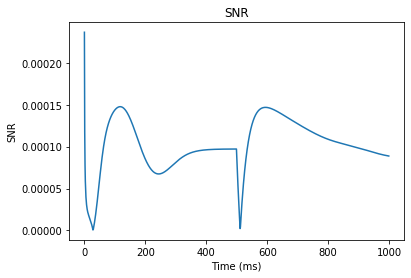

In [11]:
SNR=np.zeros(1000)
for t in range(1000):
    SNR[t]=2*np.abs(np.mean(E_novel[:,t_pre+t])-np.mean(E_familiar[:,t_pre+t]))/(np.var(E_novel[:,t_pre+t])+np.var(E_familiar[:,t_pre+t]))
plt.figure()
plt.title('SNR')
plt.xlabel('Time (ms)')
plt.ylabel('SNR')
plt.plot(range(1000),SNR)

plt.figure()
plt.title('Firing rate distribution under familiar stimulus')
plt.xlabel('Rate(Hz)')
plt.ylabel('Probability Density')
sns.kdeplot(r[:,t_delay-1],label='Presentation')
sns.kdeplot(r[:,t_max-1],label='Delay')
plt.savefig('Figures/distribution_familiar.png')

#Overlap
plt.figure()
plt.ylim(0,1)
plt.title('Overlap under familiar stimulus')
plt.xlabel('Time(s)')
plt.ylabel('Overlap(m)')

for i in range(p):
    I=I0*xi_pattern[i]
    r[:,0]=r0
    for t in range(1,t_pre):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
    for t in range(t_pre,t_delay):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(I+xi))/tau*dt #equation 1
    for t in range(t_delay,t_max):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
    p_r=np.zeros(t_max-t_p)
    for t in range(0,t_max-t_p):
        p_r[t]=scipy.stats.pearsonr(r[:,t+t_p],r_pattern[i])[0]
    plt.plot(range(0,t_max-t_p),p_r)
plt.savefig("Figures/overlap_familiar.png")

In [17]:
print(E_novel[:,t_delay])

[-43164.61231176 -41554.26172718 -42808.69314877 -41475.40420487
 -39767.71336006 -42344.19212185 -42173.03925208 -41622.05035232
 -41607.99372615 -37727.2712618 ]


In [18]:
print(E_familiar[:,t_delay])

[-62068.41284332 -51706.43641277 -34893.90253154 -33125.8795448
 -48851.88464377 -67131.88332689 -35527.07608843 -51408.04164733
 -53260.02083854 -35333.29496986]
